# <u>TP3</u>

## par Antoine Boissinot  - -  François Gaudreault  - -  Béatrice Lessard-Hamel

## Présenté à M. Philippe Després

### Date de remise : 19 mars 2021

In [5]:
from astropy import constants as cst
import matplotlib.pylab as plt
import numpy as np
import timeit
from numpy import sqrt
from matplotlib import animation, rc
from IPython.display import HTML


In [6]:
#Constantes utilisés
G = cst.G.value * ( 365.25 * 24 * 60 * 60) ** 2 #m^2/kg an^2
M = cst.M_sun.value #kg
m = cst.M_earth.value #kg

## Mécanique céleste - comètes

#### a. Transformation des équations
On a les équations suivantes à résoudre: 
$$ \frac{d^2x}{dt^2} = -GM\frac{x}{r^3}, \; \; \; \; \; \frac{d^2y}{dt^2} = -GM\frac{y}{r^3}. $$ 
Pour résoudre numériquement on souhaite transformer ces équations sous la forme: 
$$\frac{d\mathbf{r}}{dt} = \mathbf{f}(\mathbf{r}, t). $$
Sachant que la vitesse est la dérivée temporel de la position, on peut réécrire ces équations comme: 
$$ \frac{dv_x}{dt} = -GM\frac{x}{r^3}, \; \; \; \; \; \frac{dv_y}{dt} = -GM\frac{y}{r^3}, \\ \frac{dx}{dt} = v_x, \; \; \; \; \; \frac{dy}{dt} = v_y. $$ 
On peut donc exprimer $\mathbf{r}$ et $\mathbf{f}$ comme:
$$\mathbf{r} = \begin{pmatrix}
x \\
y \\
v_x \\ 
v_y 
\end{pmatrix}, \; \; \; \; \;  \mathbf{f} = \begin{pmatrix}
v_x \\
v_y \\
-GM\frac{x}{r^3}\\ 
-GM\frac{y}{r^3}
\end{pmatrix}.$$
Il ne nous reste plus qu'à solutionner numériquement!


#### b. RK4 à pas constant 

On souhaite résoudre ces équations avec une les conditions initiales $x = 4 × 10^9$ km, $y = 0$, $v_x = 0$
et $v_y = 500$ m/s. Pour ce faire la méthode Runge-Kutta d'ordre 4 va être utilisée.  

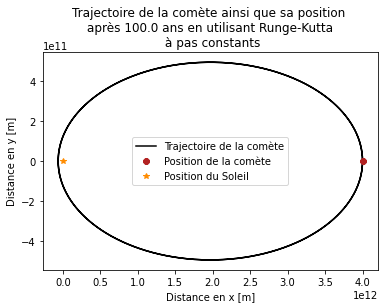

Le nombre de pas est: 25001.


In [7]:
def f(r): #f returns the vector of the time derivatives of each coordinates 
    x = r[0]
    y = r[1]
    v_x = r[2]
    v_y = r[3]
    dist = (x**2 + y**2)**(0.5)
    return np.array([v_x, v_y, -G*M*x/dist**3, -G*M*y/dist**3], float) 

def Runge_Kutta(f, r, h):
    """ 
    The function return the vector r of the updated coordinates using the Runge-Kutta method

    param 1 f: f is a vector of function
    param 2 r: r is the vector of the current coordinates
    param 3 h: h is the step between each coordinates 
    return: dr the change of the coordinates vector 
    """
    k_1 = h*f(r)
    k_2 = h*f(r + 0.5*k_1)
    k_3 = h*f(r + 0.5*k_2)
    k_4 = h*f(r + k_3)
    dr = (k_1 + 2*k_2 + 2*k_3 + k_4)/6 
    return dr
    

def orbit_constant_step(x, y, v_x, v_y, t, h):
    """
    The function return the x and y position at time t of the orbit of a comet using the 4th order Runge-Kutta to solve Newton's law of universal
    gravitation with constant time step h.    
    
    param 1 x: x is the distance in the x plane between the sun and the comet à time t = 0 [m] 
    param 2 y: y is the distance in the y plane between the sun and the comet à time t = 0 [m] 
    param 3 v_x: v_x is the speed of the comet in the x direction at time t = 0 [m/year] 
    param 4 v_y: v_y is the speed of the comet in the y direction at time t = 0 [m/year] 
    param 5 t: t is the the time duration of the simulation [year]
    param 6 h: h is the time step between each time value 
    return: x_points, y_points and t_points, the x and y list of positions corresponding to the time of t_points   
    """ 
    t_points = np.arange(0, t+h, h) #The array of time values 
    x_points = [] #The list of x positions values
    y_points = [] #The list of y positions values
    r = np.array([x, y, v_x, v_y]) #The vector of all coordinates  
  
    #We use the Runge-Kutta method
    for t in t_points:
        x_points.append(r[0])
        y_points.append(r[1])   
        r += Runge_Kutta(f, r, h) 
    
    return x_points, y_points, t_points 


#Parameters 

x = 4*10**12 #[m]
y = 0 
v_x = 0
v_y = 1000*(365.25*24*60*60) # [m/year]
t = 100 #[year]
h = 0.004

x_points, y_points, t_points = orbit_constant_step(x, y, v_x, v_y, t, h)

#Graph

plt.plot(x_points, y_points, color = "Black", label = "Trajectoire de la comète")
plt.plot(x_points[-1], y_points[-1], color = "firebrick", label = "Position de la comète", marker='8', linestyle = 'None')
plt.plot(0, 0, color = 'darkorange', marker='*', linestyle = 'None', label = "Position du Soleil")
plt.xlabel("Distance en x [m]")
plt.ylabel("Distance en y [m]")
plt.title("Trajectoire de la comète ainsi que sa position \n après {} ans en utilisant Runge-Kutta \n à pas constants".format(t_points[-1]))
plt.legend()
plt.show()
print("Le nombre de pas est: {}.".format(len(t_points)))

Par inspection on trouve qu'il faut un $h$ d'environ 0.01 pour avoir 2 périodes d'orbites supperposés, sachant que le temps d'un orbite est d'environ 50 ans on peut obtenir l'erreur relative sur la distance finale de l'orbite pour différents pas:  

In [8]:
#Check the distance error after one orbit with different steps 

h = np.linspace(0.0008, 0.01, 20) #Different h value to see how the algorithm perform 
error_h = [] #Distance between the intial point and the point after a period
for i in h:
    x_i, y_i, t_i = orbit_constant_step(x, y, v_x, v_y, t, i)
    end_point_x = x_i[-1] 
    end_point_y = y_i[-1]
    distance = np.sqrt((end_point_x - x)**2 + (end_point_y - y)**2)
    error_h.append(distance)

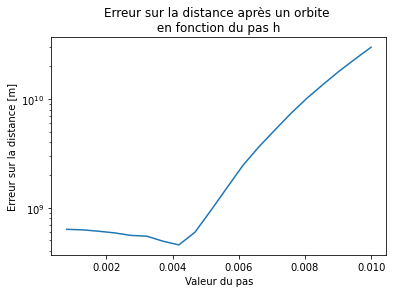

In [9]:
plt.plot(h, error_h)
plt.xlabel("Valeur du pas")
plt.ylabel("Erreur sur la distance [m]")
plt.title("Erreur sur la distance après un orbite \n en fonction du pas h ".format(t_points[-1]))
plt.yscale("log")
plt.show()

In [10]:
#Check the time to calculate with each previous step
time_step = [] # The calculation time for each step

#We'll only do one calculation for each step to save some time
for i in h:
    time = timeit.timeit('[orbit_constant_step(x, y, v_x, v_y, t, i)]', number = 1, globals=globals()) 
    time_step.append(time)

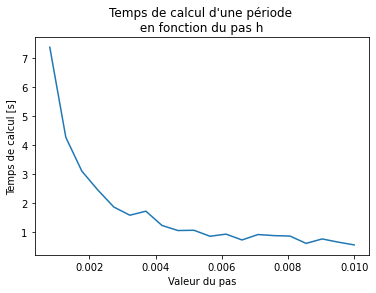

In [11]:
plt.plot(h, time_step)
plt.xlabel("Valeur du pas")
plt.ylabel("Temps de calcul [s]")
plt.title("Temps de calcul d'une période \n en fonction du pas h ".format(t_points[-1]))
plt.show()

On remarque qu'à partir de 0.004 l'erreur semble être minimale, puis recommence à augmenter, cela est peut-être dû au fait que lorsque les nombres deviennent très petits l'erreur numérique entre en compte. Pour ce qui est du temps de calcul, celui-ci semble suivre une exponenteille décroissante. Finalement, selon l'application, il serait possible d'établir un critère entre le temps de calcul et la précision souhaitée. Dans notre cas, le critère est le point approximatif où l'erreur sur la distance recommence à augmenter. 

#### c. RK4 à pas variable
Afin d'augmenter substantiellement la vitesse de calcul, il est possible de faire varier le pas de temps entre chaque itération. L'erreur maximale admise pour augmenter la vitesse est $\delta = 1$ km. 

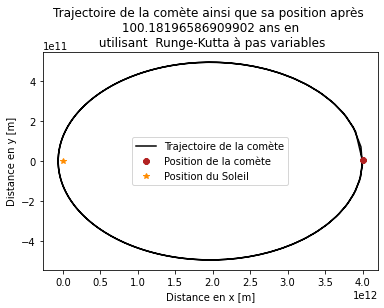

Le nombre de pas est: 329, il y a donc 987 itérations de Runge-Kutta à calculer.


In [12]:
def orbit_variable_step(x, y, v_x, v_y, t, h, delta):
    """
    The function return the x and y position at time t of the orbit of a comet using the 4th order Runge-Kutta to solve Newton's law of universal
    gravitation with variable time step.    
    
    param 1 x: x is the distance in the x plane between the sun and the comet à time t = 0 [m] 
    param 2 y: y is the distance in the y plane between the sun and the comet à time t = 0 [m] 
    param 3 v_x: v_x is the speed of the comet in the x direction at time t = 0 [m/year] 
    param 4 v_y: v_y is the speed of the comet in the y direction at time t = 0 [m/year] 
    param 5 t: t is the the approximate time duration of the simulation [year]
    param 6 h: h is the time step between each time value 
    param 7 delta: delta is the maximal accepted error  
    return: x_points, y_points and t_points, the x and y list of positions corresponding to the time of t_points
    """
    
    t_points = [0] #The list of time values 
    x_points = [x] #The list of x positions values
    y_points = [y] #The list of y positions values
    
    r = np.array([x, y, v_x, v_y]) #The vector of all coordinates 
    current_t = 0 #The time at the step h 
    
    while current_t < t:  
        
        step_1 = Runge_Kutta(f, r, h) #First step of h
        step_2 = Runge_Kutta(f, r + step_1, h) # Second step of h 
        total_step = step_1 + step_2 # Total change of the two step of h 
        
        double_step = Runge_Kutta(f, r, 2*h) #Change of the step of 2h 
    
        x_error = (total_step[0] - double_step[0]) / 30 #The error value of x
        y_error = (total_step[1] - double_step[1]) / 30 #The error value of y 
        
        error = np.sqrt(x_error**2 + y_error**2) #The Euclidean error
        
        rho = 30*h*delta/(error) #Facteur permettant de déterminer la nouvelle valeur de h 
        
        
        

        if rho > 1: #Condition permettant de savoir si h est trop grand  
            current_t = current_t + 2*h #On ajuste le temps 
            
            r += total_step + (total_step - double_step)/15 #Local extrapolation   
            
            x_points.append(r[0])
            y_points.append(r[1])
            t_points.append(current_t) 
            
            h = h*rho**(1/4) #New h value 
        else:     
            h = h*rho**(1/4) #New h value          
        
    return x_points, y_points, t_points  

#Parameters  
delta = 1000 #[m] 
x = 4*10**12 #[m]
y = 0 
v_x = 0
v_y = 1000*(365.25*24*60*60) # [m/year]
t = 100 #[year]
h = 0.004      
   
x_points, y_points, t_points = orbit_variable_step(x, y, v_x, v_y, t, h, delta)


#Graph

plt.plot(x_points, y_points, color = "Black", label = "Trajectoire de la comète")
plt.plot(x_points[-1], y_points[-1], color = "firebrick", label = "Position de la comète", marker='8', linestyle = 'None')
plt.plot(0, 0, color = 'darkorange', marker='*', linestyle = 'None', label = "Position du Soleil")
plt.xlabel("Distance en x [m]")
plt.ylabel("Distance en y [m]")
plt.title("Trajectoire de la comète ainsi que sa position après \n {} ans en \n utilisant  Runge-Kutta à pas variables".format(t_points[-1]))
plt.legend()
plt.show()

print("Le nombre de pas est: {}".format(len(t_points)) + ", il y a donc {} itérations de Runge-Kutta à calculer.".format(3*len(t_points)))

Cette méthode nous permet d'économiser beaucoup de temps de calcul, car le nombre de pas totaux effectués est bien plus petit qu'avec la méthode à pas constants, ce qui a pour effet de beaucoup réduire le temps de calcul. 

In [13]:
#Temps de calcul, on moyenne sur 10 itérations 

#Parameters of the calculation
delta = 1000 #[m] 
x = 4*10**12 #[m]
y = 0 
v_x = 0
v_y = 1000*(365.25*24*60*60) # [m/year]
t = 100 #[year]
h = 0.004      

time_constant_step = timeit.timeit('[orbit_constant_step(x, y, v_x, v_y, t, h)]', number = 10, globals=globals())/10
time_variable_step = timeit.timeit('[orbit_variable_step(x, y, v_x, v_y, t, h, delta)]', number = 10, globals=globals())/10

print("Le temps moyen pour la méthode à pas constants est: {}".format(time_constant_step))
print("Le temps moyen pour la méthode à pas variables est: {}".format(time_variable_step))
print("La méthode à pas variable est donc environ {} fois plus rapide".format(int(round(time_constant_step / time_variable_step, 0 ))))

Le temps moyen pour la méthode à pas constants est: 1.2724627930903807
Le temps moyen pour la méthode à pas variables est: 0.1049799396074377
La méthode à pas variable est donc environ 12 fois plus rapide


Cette vitesse de calcul vient toutefois à un prix, le nombre de points calculées et moins important. Mais ce nombre et surtout chacun de ces points peut avoir une erreur comprise entre -1 km et 1 km, soit $[-\delta, \, \delta]$. Plus encore, cette erreur est cumulative, mais elle peut aussi bien dévier positivement que négativement, ce qui la rendrait moins précise que la Runge-Kutta d'ordre 4. Toutefois, en ayant ajouté l'extrapolation locale, la solution a une erreur d'ordre $h^6$, comparativement à la méthode de Runge-Kutta à pas constant qui a une erreur de l'ordre de $h^5$ [1]. L'erreur pour cette méthode est donc probablement plus faible que celle à pas constant. 

Afin d'aider à visualiser la taille des pas une animation a été réalisée. Entre chaque nouvelle position de la comète il y a un interval de temps constant dans la vidéo de l'animation: 

RuntimeError: Requested MovieWriter (ffmpeg) not available

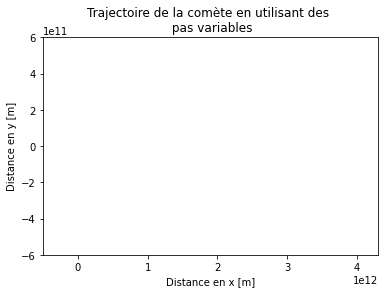

In [14]:
############## To run this you need to install ffmpeg ############## 
#Easiest way to install is to write in the Anaconda Prompt: "conda install -c conda-forge ffmpeg"

%matplotlib inline

#Parameters of the simulation

delta = 1000 #[m] 
x = 4*10**12 #[m]
y = 0 
v_x = 0
v_y = 1000*(365.25*24*60*60) # [m/year]
t = 50 #[year]
h = 0.001      
   
x_points, y_points, t_points = orbit_variable_step(x, y, v_x, v_y, t, h, delta)


x_data = []
y_data = []

fig, ax = plt.subplots()

ax.set_xlim((-0.5e12, 4.3e12))
ax.set_ylim((-6e11,6e11))







line, = ax.plot([], [], lw=2, color ="black")
ax.set_title("Trajectoire de la comète en utilisant des \n pas variables")
ax.set(xlabel='Distance en x [m]', ylabel='Distance en y [m]')

def init():
    line.set_data([], [])
    return (line,)

# animation function. 
def animate(i):
    x = x_points[i] 
    y = y_points[i]
    x_data.append(x)
    y_data.append(y)
    line.set_data(x_data, y_data)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(t_points), interval= 50, blit=True)
HTML(anim.to_html5_video())

On remarque qu'il y a une diminution importante de la grosseur des pas près de la position $(0, \, 0)$, soit la position du Soleil. C'est sans grande surprise, car on se souvient que l'accélération est donnée par:  
$$
\frac{d^{2} \mathbf{r}}{d t^{2}}=-\left(\frac{G M }{r^{3}}\right) \mathbf{r}.
$$
Cela signifie que pour une distance $r$ entre la comète et le Soleil plus petite, l'accéleration a une valeure plus élevé que lorsque $r$ est grand. Par le fait même, une valeur d'accéleration plus importante signifie un changement rapide des vitesses et donc de la position. Il est donc normal que la densité des pas soit plus élevé dans cette région. 

## Mécanique céleste - la Terre

#### d. Calcul de l'orbite de la Terre autour du soleil

In [31]:
#Constantes
h = 1 / (365.25 * 24) # ans
G = cst.G.value * ( 365.25 * 24 * 60 * 60) ** 2 #m^2/kg ans^2
M = cst.M_sun.value #kg
m = cst.M_earth.value #kg

In [32]:
#Fonction dépendante de r selon l'équation 9 décrivant le mouvement
def f(r):
    x = r[0]
    vx = r[1]
    y = r[2]
    vy = r[3]
    R = sqrt(x ** 2 + y ** 2)
    return np.array([ vx, -G * M * x / R ** 3, vy, -G * M * y / R ** 3 ])


In [33]:
#Méthode de Verlet pour rajouter la dépendance temporelle

def orbite(t_0,t_f,x0,y0,vx0,vy0):
    xn = []
    yn = []
    tn = np.arange(t_0, t_f, h) #liste de temps entre t_0 et T_f avec un pas h
    r = np.array([x0, vx0, y0, vy0])
    #Premier pas
    demi = 0.5 * h * f(r) 
    vxn = r[1] + demi[1] #vx(t+h/2)
    vyn = r[3] + demi[3] #vy(t+h/2)
    for t in tn: #Calcul pour tous les temps
        xn.append(r[0])
        yn.append(r[2])
        r[0] += h * vxn
        r[2] += h * vyn
        k = h * f(r)
        r[1] = vxn+ 0.5 * k[1]
        r[3] = vyn + 0.5 * k[3]
        demi = 0.5 * h * f(r)
        vxn += k[1]
        vyn+= k[3]
    return xn,yn #Valeurs de positions en x et y pour tous les temps 

In [34]:
# Valeurs initiales 

p = 1.4710 * 10 ** 11 #m
vt = 3.0287 * 10 ** 4 * 365.25 * 24 * 60 * 60 #m/an
theta = np.array([np.pi/4,np.pi/3,np.pi/2]) # On a choisi quelques valeurs d'angles pour varier la position initiale
x0 = p*np.cos(theta) #Position initiale x
y0 = p*np.sin(theta) #Position initiale y
vx0 = vt*np.cos(np.pi/2+theta) #Vitesse initiale x
vy0 = vt*np.sin(np.pi/2+theta) #Vitesse initiale y

# 5 orbites à des positions initiales différentes 
x1,y1 = orbite(0,2,p,0,0,vt)
x2,y2 = orbite(0,2,x0[0],y0[0],vx0[0],vy0[0])
x3,y3 = orbite(0,2,x0[1],y0[1],vx0[1],vy0[1])
x4,y4 = orbite(0,2,x0[2],y0[2],vx0[2],vy0[2])
x5,y5 = orbite(0,2,0,p,vt,0)

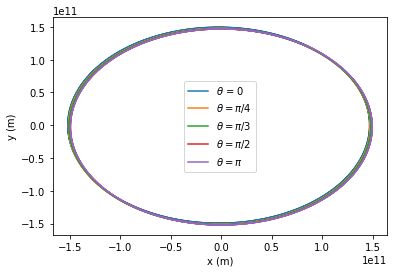

In [35]:
# Plot orbites
plt.plot(x1,y1,label = '$\\theta$ = 0')
plt.plot(x2,y2,label = '$\\theta = \pi/4$')
plt.plot(x3,y3,label = '$\\theta = \pi/3$')
plt.plot(x4,y4,label = '$\\theta = \pi/2$')
plt.plot(x5,y5,label = '$\\theta = \pi$')

plt.legend()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

En faisant varier légèrement la position initiale, on vient varier légèrement l'orbite. 

#### e. Énergie potentielle et cinétique. 

In [36]:
# On reprend la même fonction que en d. 
def orbite(t_0,t_f,x0,y0,vx0,vy0):
    xn = []
    yn = []
    U = []
    K= []
    tn = np.arange(t_0, t_f, h) #liste de temps entre t_0 et T_f avec un pas h
    r = np.array([x0, vx0, y0, vy0])
    #Premier pas
    demi = 0.5 * h * f(r) 
    vxn = r[1] + demi[1] #vx(t+h/2)
    vyn = r[3] + demi[3] #vy(t+h/2)
    for t in tn: #Calcul pour tous les temps
        xn.append(r[0])
        yn.append(r[2])
        r[0] += h * vxn
        r[2] += h * vyn
        k = h * f(r)
        r[1] = vxn+ 0.5 * k[1]
        r[3] = vyn + 0.5 * k[3]
        demi = 0.5 * h * f(r)
        vxn += k[1]
        vyn+= k[3]
        #Calcul des énergies
        U.append(-cst.G.value * M * m / sqrt(r[0] ** 2 + r[2] ** 2))
        K.append(0.5 * m * (r[1] ** 2 + r[3] ** 2) / (365.25 * 24 * 60 * 60) ** 2)
    E = np.array(K) + np.array(U)
    return xn,yn,K,U,E,tn #Valeurs d'énergies cinétiques et potentiels  


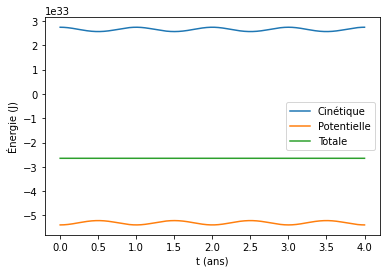

In [37]:
# Caclul de la position de l'orbite et de la variation des énergies pour 4 ans avec la méthode de Verlet
xV,yV,KV,UV,EV,tV = orbite(0,4,p,0,0,vt)

plt.plot(tV, KV,label = "Cinétique")
plt.plot(tV, UV,label = "Potentielle")
plt.plot(tV, EV,label = "Totale")
plt.xlabel('t (ans)')
plt.ylabel('Énergie (J)')
plt.legend()
plt.show()

#### f. RK2 pour calcul de l'orbite

In [38]:
def RK2(f, r, h):
    k_1 = h*f(r)
    k_2 = h*f(r + 0.5*k_1)
    dr = k_2
    return dr
#On reprend la même méthode que pour RK4 mais on utilise RK2
def orbit_rk2(x, y, v_x, v_y, t, h):
    t_points = np.arange(0, t+h, h) #The array of time values 
    x_points = [] #The list of x positions values
    y_points = [] #The list of y positions values
    U = []
    K= []
    r = np.array([x, y, v_x, v_y]) #The vector of all coordinates  
    #We use the rk2 method
    for t in t_points:
        x_points.append(r[0])
        y_points.append(r[1])   
        r += RK2(f, r, h) 
        #Calcul des énergies
        U.append(-cst.G.value * M * m / sqrt(r[0] ** 2 + r[1] ** 2))
        K.append(0.5 * m * (r[2] ** 2 + r[3] ** 2) / (365.25 * 24 * 60 * 60) ** 2)
    E = np.array(K) + np.array(U)
    return x_points, y_points, t_points ,E,U,K

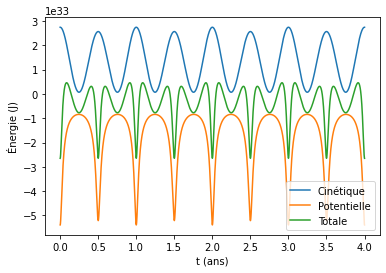

In [39]:
# Caclul de la position de l'orbite et de la variation des énergies pour 4 ans avec la méthode RK2
x2,y2,t2,E2,U2,K2 = orbit_rk2(p,0,0,vt,4,h)

plt.plot(t2, K2,label = "Cinétique")
plt.plot(t2, U2,label = "Potentielle")
plt.plot(t2, E2,label = "Totale")
plt.xlabel('t (ans)')
plt.ylabel('Énergie (J)')
plt.legend()
plt.show()

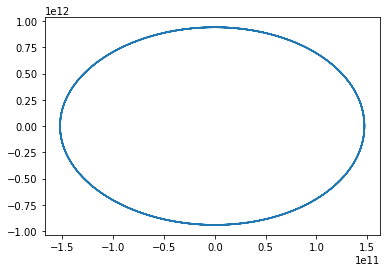

## Mécanique céleste - Mars

## Références
1. Newman, Mark. Computational physics. CreateSpace Independent Publ., 2013.